<a href="https://colab.research.google.com/github/bessszilard/Udacity-Self-Driving-Car-Engineer-Nanodegree-Program/blob/Pr4_YUV_img/Project-4-Behavioral-Cloning/Behavioral_cloning_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/bessszilard/Self-Driving-Car-Simulator-Data

fatal: destination path 'Self-Driving-Car-Simulator-Data' already exists and is not an empty directory.


In [2]:
!ls
!ls Self-Driving-Car-Simulator-Data

model.h5  sample_data  Self-Driving-Car-Simulator-Data
driving_log.csv  IMG  LICENSE  README.md


In [3]:
import csv
import os
import numpy as np
import matplotlib.pyplot as plt
import keras
import matplotlib.image as mpimg
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPool2D, Dropout, Flatten, Dense, Lambda
from keras.layers import Cropping2D, Conv2D
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import pandas as pd
import random
from google.colab import files

Using TensorFlow backend.


In [0]:
# lines = []
# with open("../data/driving_log.csv") as csvfile:
#     reader = csv.reader(csvfile)
#     for line in reader:
#         lines.appedn

In [0]:
# datadir = 'Self-Driving-Car-Simulator-Data'
# colums = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
# data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = colums)
# pd.set_option('display.max_colwidth', -1)
# data.head()

lines = []
with open('Self-Driving-Car-Simulator-Data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)
        
images = []
measurements = []

def path_to_image(dir, line):
    filename = source_path.split('\\')[-1] 
    current_path = dir + filename
    return cv2.imread(current_path)

for line in lines:
    steering_center = float(line[3])
    
#     # create adjusted steering measurements for the side camera images
#     correction = 1 # this is a parameter to tune
#     steering_left = 1.5*steering_center + correction
#     steering_right = 1.5*steering_center - correction
            
    source_path = line[0]
    filename = source_path.split('\\')[-1]
    current_path = 'Self-Driving-Car-Simulator-Data/IMG/' + filename
    
    image = cv2.imread(current_path)
    
    dir = 'Self-Driving-Car-Simulator-Data/IMG/'
    image_center = path_to_image(dir, line[0])
#     image_left   = path_to_image(dir, line[1])
#     image_right  = path_to_image(dir, line[2])
    
    images.append(image_center)
    measurement = float(line[3])
    measurements.append(measurement)
#     images.extend((image_center, image_left, image_right))
#     measurements.extend((steering_center, steering_left, steering_right))

# augmented_images = images
# augemented_measurements = measurements
# del images, measurements

# augmented_images, augemented_measurements = [], []  
# for image, measurement in zip(images, measurements):
#     augmented_images.append(image)
#     augemented_measurements.append(measurement)
#     augmented_images.append(cv2.flip(image, 1))
#     augemented_measurements.append(-measurement)




In [0]:
def img_preprocess(img):
#     img = img[60:135, :, :]                    # we don't need the top of the picture, because it is only terrian. 
                                               # We don't need also the bottom of the image, because it only the hood of the car
    img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV) # Nvidia model needed this color space
#     img = cv2.GaussianBlur(img, (3, 3), 0)     # Gaussian blur removes noise
#     img = cv2.resize(img, (200, 66))
#     img = img / 255 - 0.5
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0
(160, 320, 3)


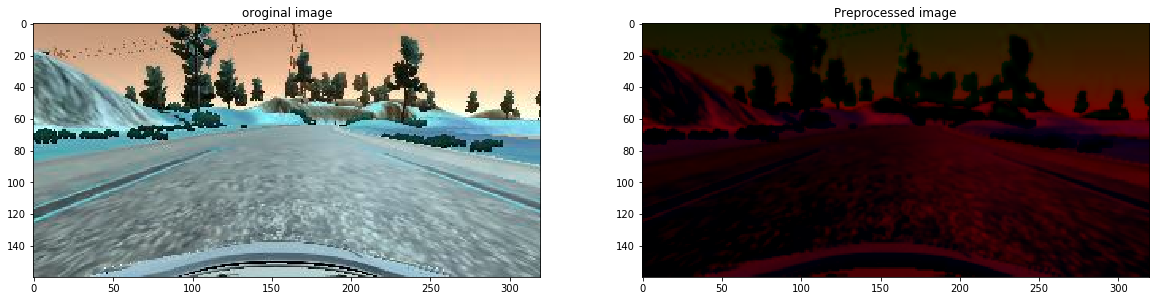

In [14]:
index = random.randint(0, len(measurements)-1)
# plt.imshow(images[index])
print(measurements[index])

fig, ax = plt.subplots(1, 2, figsize=(20, 20))
ax[0].imshow(images[index])
ax[0].set_title("oroginal image")
ax[1].imshow(img_preprocess(images[index]))
ax[1].set_title("Preprocessed image")
print(images[index].shape)

In [0]:
# #clear RAM

# # X_train = np.array(augmented_images)
# y_train = np.array(augemented_measurements)

# # X_train = np.array(list(map(img_preprocess, augmented_images)))    # iteratively goes through the whole array
# X_train = np.zeros((len(augmented_images), 66, 200, 3))

# del lines, images, measurements

# for i in range(len(augmented_images)):
#     X_train[i] = img_preprocess(augmented_images[i])

# # X_train = np.array(img_preprocess(augmented_images))
# # X_valid = np.array(list(map(img_preprocess, X_valid)))    # iteratively goes through the whole array
# del augmented_images, augemented_measurements

# print(X_train.shape)

In [16]:
from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(lines, test_size=0.2)

import cv2
import numpy as np
import sklearn

def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                filename = batch_sample[0].split('\\')[-1]
                current_path = 'Self-Driving-Car-Simulator-Data/IMG/' + filename
                center_image = cv2.imread(current_path)
                center_angle = float(batch_sample[3])
                
                center_image = img_preprocess(center_image)
                images.append(center_image)
                angles.append(center_angle)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)

# Set our batch size
batch_size=32

# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=batch_size)
validation_generator = generator(validation_samples, batch_size=batch_size)

train_generator_data = generator(train_samples, batch_size=batch_size)
print(np.array(train_generator_data))

<generator object generator at 0x7f0732c69bf8>


In [21]:
ch, row, col = 3, 160, 320  # Trimmed image format

model = Sequential()
# model.add(Lambda(lambda x: ((x / 255.0) - 0.5), input_shape=(160, 320, 3)))
# model.add(Lambda(lambda x: (x), input_shape=(66, 200, 3)))
model.add(Lambda(lambda x: x/127.5 - 1., input_shape=(row, col, ch), output_shape=(row, col, ch)))
model.add(Cropping2D(cropping=((70, 25),(0, 0))))
model.add(Conv2D(24, (5, 5), strides=(2, 2), activation='relu'))
model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='relu'))
model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(1))

optimizer = Adam(lr = 0.5e-3)
model.compile(loss='mse', optimizer=optimizer)
# history_object = model.fit(X_train, y_train, validation_split=0.2, shuffle=True, epochs=7)
history_object = model.fit_generator(train_generator,
                                    steps_per_epoch=np.ceil(len(train_samples)/batch_size),
                                    validation_data=validation_generator,
                                    validation_steps=np.ceil(len(validation_samples)/batch_size),
                                    epochs=5, verbose=1)

Epoch 1/5
256/256 [==============================] - 14s 54ms/step - loss: 0.0339 - val_loss: 0.0233
Epoch 2/5
256/256 [==============================] - 13s 51ms/step - loss: 0.0265 - val_loss: 0.0204
Epoch 3/5
256/256 [==============================] - 13s 51ms/step - loss: 0.0238 - val_loss: 0.0207
Epoch 4/5
256/256 [==============================] - 13s 51ms/step - loss: 0.0225 - val_loss: 0.0183
Epoch 5/5
256/256 [==============================] - 13s 51ms/step - loss: 0.0216 - val_loss: 0.0177


dict_keys(['val_loss', 'loss'])


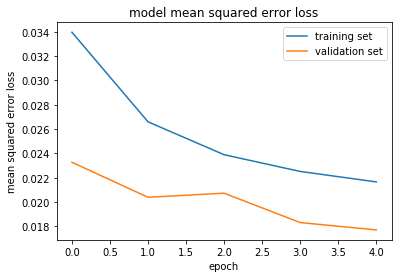

In [22]:
### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [0]:
model.save('model.h5')
# !ls
files.download('model.h5')